# FDA Approval Event Analysis - Always Buy Strategy Evaluation

This notebook analyzes the performance of a naive "always buy" strategy compared to the TimeSeriesRidge and XGBoostDecile models for FDA drug approval events.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Metrics for performance analysis
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import pearsonr, spearmanr

# Import the FDA analysis modules
from analysis import DataLoader, FeatureEngineer, Analysis
from analysis import TimeSeriesRidge, XGBoostDecileModel

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

# Create output directory
os.makedirs('results/all_buy_fda', exist_ok=True)

## Create Always Buy Model

First, let's define a naive model that always predicts buying (positive return).

In [16]:
class AlwaysBuyModel:
    """
    A naive model that always predicts buying (positive return).
    This serves as a baseline to compare with more sophisticated models.
    """
    def __init__(self, prediction_value=0.01):
        """
        Initialize the model.
        
        Parameters:
        prediction_value (float): The constant positive return prediction value
        """
        self.prediction_value = prediction_value
        
    def fit(self, X, y):
        """Fit method (does nothing as this is a naive model)"""
        # Simply store the mean of the target for reference
        self.mean_target = np.mean(y)
        return self
    
    def predict(self, X):
        """Always predict the same positive return value"""
        return np.full(len(X), self.prediction_value)
    
    def get_params(self, deep=True):
        """Return model parameters (for compatibility with sklearn)"""
        return {'prediction_value': self.prediction_value}

## Load and Prepare Data

Load the FDA and stock data, create the target variable, and calculate features.

In [17]:
# Set paths to data files - update these to your local paths
stock_path = '/home/brand/MIT/DMPS-Data/fda-intraday/crsp-fda-2020-2025.csv'  # Stock data
fda_path = '/home/brand/MIT/DMPS-Data/fda-scrapped/fda_ticker_list_2000_to_2024.csv'  # FDA approval data

# Initialize data loader with 60-day window around approval events
print("Initializing data loader...")
data_loader = DataLoader(
    fda_path=fda_path,
    stock_path=stock_path,
    window_days=60
)

# Initialize feature engineer with 5-day prediction window
feature_engineer = FeatureEngineer(prediction_window=5)

# Initialize analysis
analysis = Analysis(data_loader, feature_engineer)

Initializing data loader...


In [18]:
# Load and prepare data
print("Loading and preparing data...")
data = analysis.load_and_prepare_data()

# Display data summary
print("\nData Overview:")
print(f"- Total observations: {len(data)}")
print(f"- Unique FDA events: {data[['ticker', 'Approval Date']].drop_duplicates().shape[0]}")
print(f"- Unique tickers: {data['ticker'].nunique()}")
print(f"- Date range: {data['date'].min()} to {data['date'].max()}")

# Train the original models
print("Training original models...")
original_models = analysis.train_models(test_size=0.2)

Loading and preparing data...
Found 1773 unique FDA approval events
Filtered stock data to 326 tickers with FDA approvals


/home/brand/MIT/ICBS/analysis.py:19: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  fda_data = pd.read_csv(self.fda_path, parse_dates=['Approval Date'])
/home/brand/MIT/ICBS/analysis.py:50: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  stock_data = pd.read_csv(self.stock_path, parse_dates=[date_col])


Created data for 130 FDA approval events with available stock data
Loaded data shape: (8391, 40)
Created target variable: 7781 non-null values


/home/brand/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/brand/.local/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/brand/.local/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/brand/.local/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/brand/.local/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/brand/.local/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Me


Feature columns being used:
 1. cusip
 2. bidlo
 3. askhi
 4. prc
 5. vol
 6. ret
 7. bid
 8. ask
 9. openprc
10. numtrd
11. retx
12. namedt
13. nameendt
14. Ticker
15. __index_level_0__
16. momentum_5
17. momentum_10
18. momentum_20
19. delta_momentum_5_10
20. delta_momentum_10_20
21. volatility_5
22. volatility_10
23. volatility_20
24. delta_volatility_5_10
25. delta_volatility_10_20
26. log_ret
27. ret_lag_1
28. ret_lag_2
29. ret_lag_3
30. pre_approval_ret
31. prev_day_volatility
32. prev_day_vol_std

Final feature matrix shape: (7781, 19)
Final feature columns:
 1. bidlo
 2. askhi
 3. prc
 4. vol
 5. ret
 6. bid
 7. ask
 8. retx
 9. __index_level_0__
10. momentum_5
11. volatility_5
12. volatility_10
13. volatility_20
14. delta_volatility_5_10
15. delta_volatility_10_20
16. log_ret
17. ret_lag_1
18. ret_lag_2
19. ret_lag_3
Features shape: (7781, 19), Target shape: (7781,)

Data Overview:
- Total observations: 8391
- Unique FDA events: 122
- Unique tickers: 50
- Date range: 2021-01-

/home/brand/.local/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=6.49692e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


## Implement Always Buy Strategy

Now let's implement and evaluate the naive "always buy" strategy.

In [19]:
# Define functions to calculate performance metrics
def calculate_sharpe_ratio(returns, risk_free_rate=0.02):
    """
    Calculate annualized Sharpe ratio
    
    Parameters:
    returns (array-like): Series of returns (assumed to be daily)
    risk_free_rate (float): Annual risk-free rate (default 2%)
    
    Returns:
    float: Annualized Sharpe ratio
    """
    # Convert annual risk-free rate to daily
    daily_rf = (1 + risk_free_rate) ** (1/252) - 1
    
    # Calculate excess returns
    excess_returns = returns - daily_rf
    
    # Calculate annualized Sharpe ratio (assuming daily returns)
    sharpe = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)
    
    return sharpe

def evaluate_model_performance(model, X_train, y_train, X_test, y_test, model_name):
    """Evaluate model performance with comprehensive metrics"""
    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Basic metrics
    metrics = {
        "Train MSE": mean_squared_error(y_train, y_pred_train),
        "Test MSE": mean_squared_error(y_test, y_pred_test),
        "Train RMSE": np.sqrt(mean_squared_error(y_train, y_pred_train)),
        "Test RMSE": np.sqrt(mean_squared_error(y_test, y_pred_test)),
        "Train MAE": mean_absolute_error(y_train, y_pred_train),
        "Test MAE": mean_absolute_error(y_test, y_pred_test),
        "Train R²": r2_score(y_train, y_pred_train),
        "Test R²": r2_score(y_test, y_pred_test),
    }
    
    # Correlation metrics
    if not all(y_pred_test == y_pred_test[0]):  # Check if predictions are not all the same
        pearson_corr, pearson_p = pearsonr(y_test, y_pred_test)
        spearman_corr, spearman_p = spearmanr(y_test, y_pred_test)
        metrics["Pearson Correlation"] = pearson_corr
        metrics["Pearson p-value"] = pearson_p
        metrics["Spearman Correlation"] = spearman_corr
        metrics["Spearman p-value"] = spearman_p
    else:  # For always-buy model where all predictions are the same
        metrics["Pearson Correlation"] = np.nan
        metrics["Pearson p-value"] = np.nan
        metrics["Spearman Correlation"] = np.nan
        metrics["Spearman p-value"] = np.nan
    
    # Directional accuracy (sign prediction)
    direction_correct_test = np.sum(np.sign(y_pred_test) == np.sign(y_test))
    metrics["Direction Accuracy"] = direction_correct_test / len(y_test)
    
    # Calculate Sharpe ratio (strategy returns)
    # For always-buy, this is just the actual returns since all predictions are positive
    # For other models, this is sign(prediction) * actual return
    strategy_returns = np.sign(y_pred_test) * y_test
    metrics["Sharpe Ratio"] = calculate_sharpe_ratio(strategy_returns)
    
    # For always-buy model, also calculate percentage of positive returns
    metrics["Positive Returns %"] = np.mean(y_test > 0) * 100
    
    # Count positive/negative actual returns to understand distribution
    metrics["Positive Returns Count"] = np.sum(y_test > 0)
    metrics["Negative Returns Count"] = np.sum(y_test < 0)
    metrics["Zero Returns Count"] = np.sum(y_test == 0)
    metrics["Total Returns Count"] = len(y_test)
    
    # Print summary
    print(f"\n{model_name} Model Performance:")
    print(f"Test RMSE: {metrics['Test RMSE']:.6f}")
    print(f"Test MAE: {metrics['Test MAE']:.6f}")
    print(f"Test R²: {metrics['Test R²']:.6f}")
    print(f"Direction Accuracy: {metrics['Direction Accuracy']:.2%}")
    print(f"Positive Returns: {metrics['Positive Returns %']:.2f}%")
    print(f"Sharpe Ratio: {metrics['Sharpe Ratio']:.4f}")
    
    return metrics, y_pred_test

In [20]:
# Create and evaluate the always-buy model
# First, get the mean of the target in the training set to use as prediction value
y_train_mean = np.mean(analysis.y_train)
print(f"Average return in training set: {y_train_mean:.6f}")

# Create always buy model with the mean return as prediction value
always_buy_model = AlwaysBuyModel(prediction_value=abs(y_train_mean))
always_buy_model.fit(analysis.X_train, analysis.y_train)

# Add to models dictionary
analysis.models['AlwaysBuy'] = always_buy_model

# Evaluate all models including the always-buy model
performance_metrics = {}
test_predictions = {}

for name, model in analysis.models.items():
    metrics, y_pred = evaluate_model_performance(
        model, analysis.X_train, analysis.y_train, analysis.X_test, analysis.y_test, name
    )
    performance_metrics[name] = metrics
    test_predictions[name] = y_pred

Average return in training set: 0.000489

TimeSeriesRidge Model Performance:
Test RMSE: 0.041524
Test MAE: 0.027290
Test R²: -0.001716
Direction Accuracy: 50.20%
Positive Returns: 52.11%
Sharpe Ratio: 0.8088


/home/brand/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but TimeSeriesRidge was fitted without feature names
  warnings.warn(
/home/brand/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but TimeSeriesRidge was fitted without feature names
  warnings.warn(



XGBoostDecile Model Performance:
Test RMSE: 0.042600
Test MAE: 0.028187
Test R²: -0.054281
Direction Accuracy: 53.63%
Positive Returns: 52.11%
Sharpe Ratio: 1.6016

AlwaysBuy Model Performance:
Test RMSE: 0.041638
Test MAE: 0.027046
Test R²: -0.007206
Direction Accuracy: 52.11%
Positive Returns: 52.11%
Sharpe Ratio: 1.5044


## Model Performance Comparison

Let's compare the performance of all models including the always-buy strategy.

In [21]:
# Create comparison DataFrame
metrics_df = pd.DataFrame(performance_metrics)

# Display key metrics
key_metrics = [
    "Direction Accuracy", 
    "Sharpe Ratio", 
    "Test RMSE", 
    "Test MAE", 
    "Test R²",
    "Positive Returns %"
]

metrics_df.loc[key_metrics]

,TimeSeriesRidge,XGBoostDecile,AlwaysBuy
Direction Accuracy,0.501972,0.536338,0.521127
Sharpe Ratio,0.808784,1.601632,1.504412
Test RMSE,0.041524,0.042600,0.041638
Test MAE,0.027290,0.028187,0.027046
Test R²,-0.001716,-0.054281,-0.007206
Positive Returns %,52.112676,52.112676,52.112676


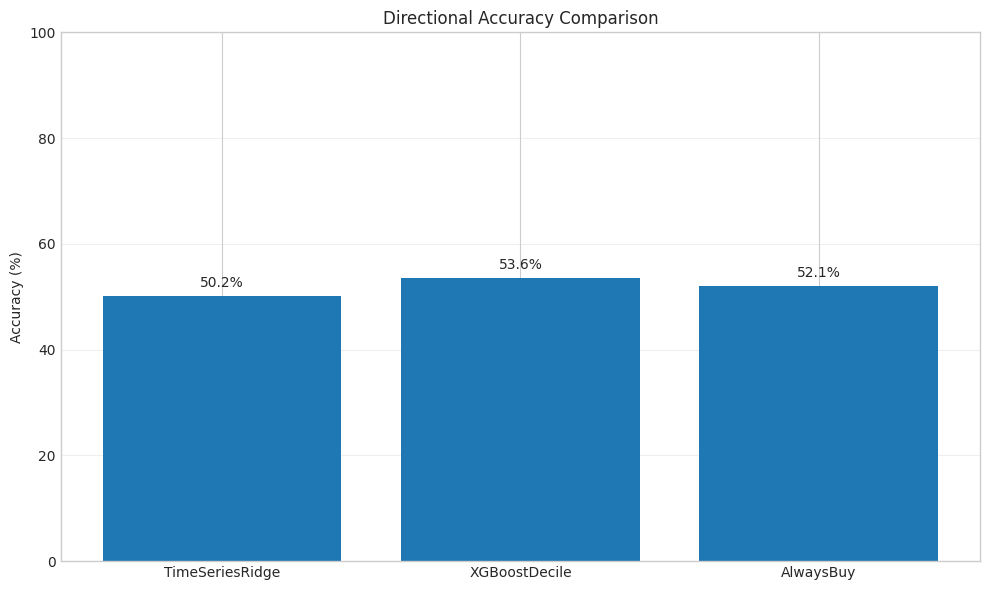

In [22]:
# Visualize directional accuracy comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics_df.columns, metrics_df.loc["Direction Accuracy"] * 100)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{height:.1f}%', ha='center', va='bottom')

plt.title('Directional Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('results/all_buy_fda/directional_accuracy_comparison.png')
plt.show()

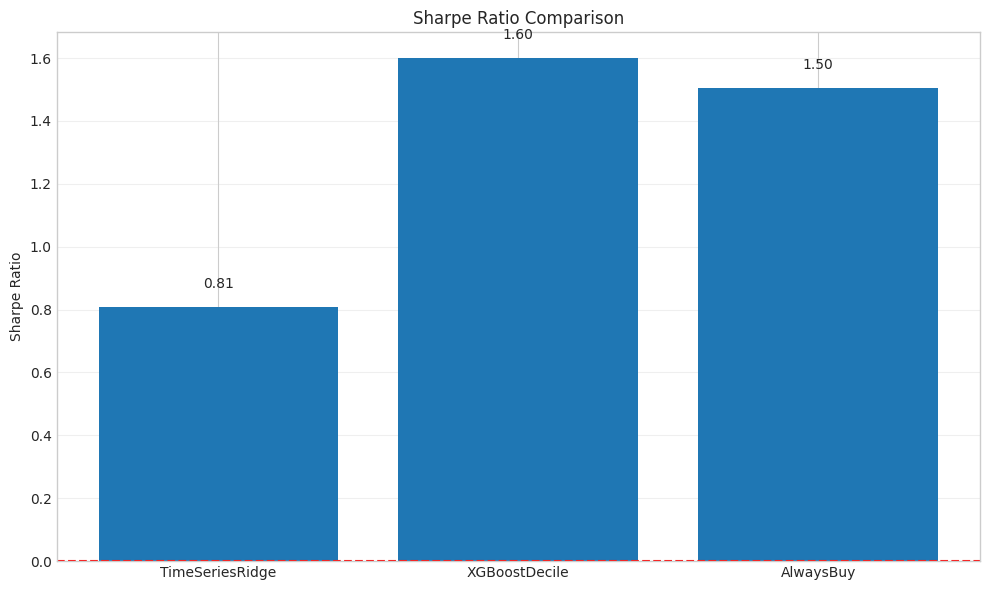

In [23]:
# Visualize Sharpe ratio comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics_df.columns, metrics_df.loc["Sharpe Ratio"])

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.05,
            f'{height:.2f}', ha='center', va='bottom')

plt.title('Sharpe Ratio Comparison')
plt.ylabel('Sharpe Ratio')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('results/all_buy_fda/sharpe_ratio_comparison.png')
plt.show()

## Value Added Analysis

Let's calculate how much value the more complex models add relative to the always-buy strategy.

In [24]:
# Calculate value added by each model relative to always-buy
always_buy_metrics = performance_metrics['AlwaysBuy']
value_added = {}

for name, metrics in performance_metrics.items():
    if name != 'AlwaysBuy':
        # Calculate improvement in key metrics
        value_added[name] = {
            'Direction Accuracy Improvement': metrics['Direction Accuracy'] - always_buy_metrics['Direction Accuracy'],
            'Sharpe Ratio Improvement': metrics['Sharpe Ratio'] - always_buy_metrics['Sharpe Ratio'],
            'RMSE Improvement': always_buy_metrics['Test RMSE'] - metrics['Test RMSE'],
            'MAE Improvement': always_buy_metrics['Test MAE'] - metrics['Test MAE'],
            'R² Improvement': metrics['Test R²'] - always_buy_metrics['Test R²']
        }

# Create value added DataFrame
value_added_df = pd.DataFrame(value_added)
value_added_df

,TimeSeriesRidge,XGBoostDecile
Direction Accuracy Improvement,-0.019155,0.015211
Sharpe Ratio Improvement,-0.695628,0.097220
RMSE Improvement,0.000114,-0.000962
MAE Improvement,-0.000244,-0.001141
R² Improvement,0.005489,-0.047075


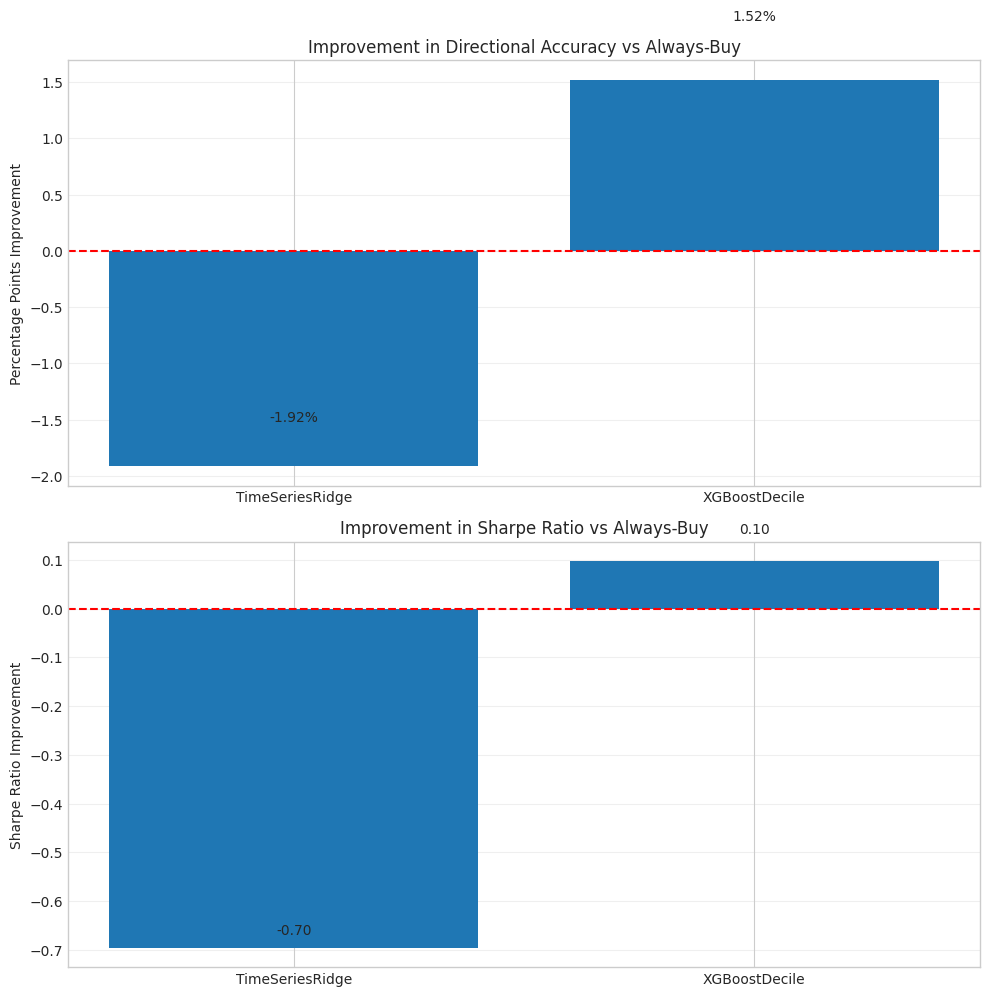

In [25]:
# Visualize value added in directional accuracy and Sharpe ratio
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Directional Accuracy Improvement
bars1 = ax1.bar(value_added_df.columns, value_added_df.loc['Direction Accuracy Improvement'] * 100)
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.2f}%', ha='center', va='bottom' if height > 0 else 'top')
ax1.set_title('Improvement in Directional Accuracy vs Always-Buy')
ax1.set_ylabel('Percentage Points Improvement')
ax1.axhline(y=0, color='r', linestyle='--')
ax1.grid(axis='y', alpha=0.3)

# Sharpe Ratio Improvement
bars2 = ax2.bar(value_added_df.columns, value_added_df.loc['Sharpe Ratio Improvement'])
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{height:.2f}', ha='center', va='bottom' if height > 0 else 'top')
ax2.set_title('Improvement in Sharpe Ratio vs Always-Buy')
ax2.set_ylabel('Sharpe Ratio Improvement')
ax2.axhline(y=0, color='r', linestyle='--')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('results/all_buy_fda/value_added_comparison.png')
plt.show()

## Return Distribution Analysis

Let's analyze the distribution of returns to better understand why the always-buy strategy performs the way it does.

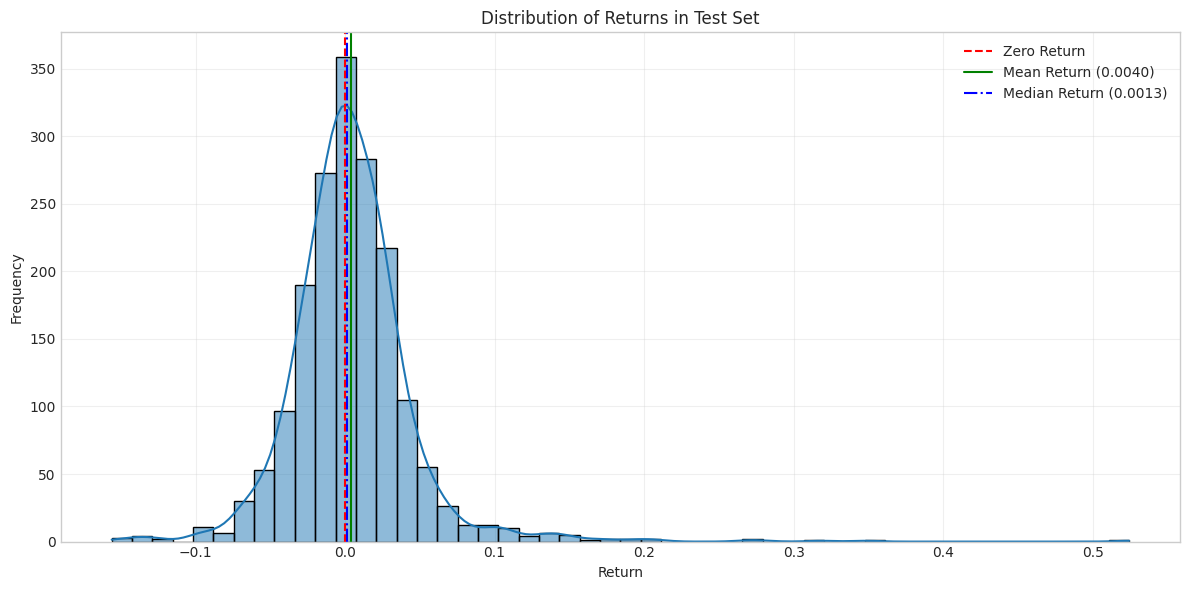

Return Statistics:
Mean Return: 0.004010
Median Return: 0.001273
Standard Deviation: 0.041489
Minimum Return: -0.156085
Maximum Return: 0.524314
Positive Returns: 925 (52.11%)
Negative Returns: 848 (47.77%)
Zero Returns: 2 (0.11%)


In [26]:
# Analyze the distribution of actual returns
plt.figure(figsize=(12, 6))
sns.histplot(analysis.y_test, kde=True, bins=50)
plt.axvline(x=0, color='r', linestyle='--', label='Zero Return')
plt.axvline(x=np.mean(analysis.y_test), color='g', linestyle='-', label=f'Mean Return ({np.mean(analysis.y_test):.4f})')
plt.axvline(x=np.median(analysis.y_test), color='b', linestyle='-.', label=f'Median Return ({np.median(analysis.y_test):.4f})')
plt.title('Distribution of Returns in Test Set')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('results/all_buy_fda/return_distribution.png')
plt.show()

# Print statistics about returns
print("Return Statistics:")
print(f"Mean Return: {np.mean(analysis.y_test):.6f}")
print(f"Median Return: {np.median(analysis.y_test):.6f}")
print(f"Standard Deviation: {np.std(analysis.y_test):.6f}")
print(f"Minimum Return: {np.min(analysis.y_test):.6f}")
print(f"Maximum Return: {np.max(analysis.y_test):.6f}")
print(f"Positive Returns: {np.sum(analysis.y_test > 0)} ({np.mean(analysis.y_test > 0):.2%})")
print(f"Negative Returns: {np.sum(analysis.y_test < 0)} ({np.mean(analysis.y_test < 0):.2%})")
print(f"Zero Returns: {np.sum(analysis.y_test == 0)} ({np.mean(analysis.y_test == 0):.2%})")

## Analyze Returns Around FDA Approval Date

Let's examine average returns around FDA approval dates to understand if there's a pattern.

In [27]:
# Calculate average returns around approval date
print("Analyzing returns around approval dates...")

# Define window for analysis
pre_days = 10
post_days = 20

# Initialize DataFrame for aligned returns
aligned_returns = pd.DataFrame(
    index=range(-pre_days, post_days + 1),
    columns=['avg_ret', 'cum_ret', 'count', 'pos_count', 'neg_count']
).fillna(0)

# Collect returns for each day relative to approval
for ticker, approval_date in data[['ticker', 'Approval Date']].drop_duplicates().values:
    event_data = data[(data['ticker'] == ticker) & (data['Approval Date'] == approval_date)].copy()
    
    # Only include events with sufficient data
    if len(event_data) < (pre_days + post_days + 1):
        continue
    
    # Get returns indexed by days to approval
    for day in range(-pre_days, post_days + 1):
        day_data = event_data[event_data['days_to_approval'] == day]
        if not day_data.empty:
            ret = day_data['ret'].iloc[0]
            aligned_returns.loc[day, 'avg_ret'] += ret
            aligned_returns.loc[day, 'count'] += 1
            if ret > 0:
                aligned_returns.loc[day, 'pos_count'] += 1
            elif ret < 0:
                aligned_returns.loc[day, 'neg_count'] += 1

# Calculate averages and cumulative returns
aligned_returns['avg_ret'] = aligned_returns['avg_ret'] / aligned_returns['count']
aligned_returns['cum_ret'] = (1 + aligned_returns['avg_ret']).cumprod() - 1
aligned_returns['pos_pct'] = aligned_returns['pos_count'] / aligned_returns['count'] * 100

# Display the aligned returns
aligned_returns

Analyzing returns around approval dates...


/tmp/ipykernel_4517/1340216055.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(0)
/tmp/ipykernel_4517/1340216055.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.017505' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  aligned_returns.loc[day, 'avg_ret'] += ret


,avg_ret,cum_ret,count,pos_count,neg_count,pos_pct
-10,-0.001332,-0.001332,44,22,22,50.000000
-9,-0.002775,-0.004104,53,20,33,37.735849
-8,0.002488,-0.001626,64,36,28,56.250000
-7,0.000182,-0.001444,72,38,34,52.777778
-6,-0.000812,-0.002254,48,20,28,41.666667
-5,-0.000215,-0.002469,34,18,16,52.941176
-4,0.001995,-0.000479,41,25,16,60.975610
-3,-0.001002,-0.001481,44,21,23,47.727273
-2,0.001160,-0.000323,52,25,27,48.076923
-1,-0.000220,-0.000543,64,32,32,50.000000


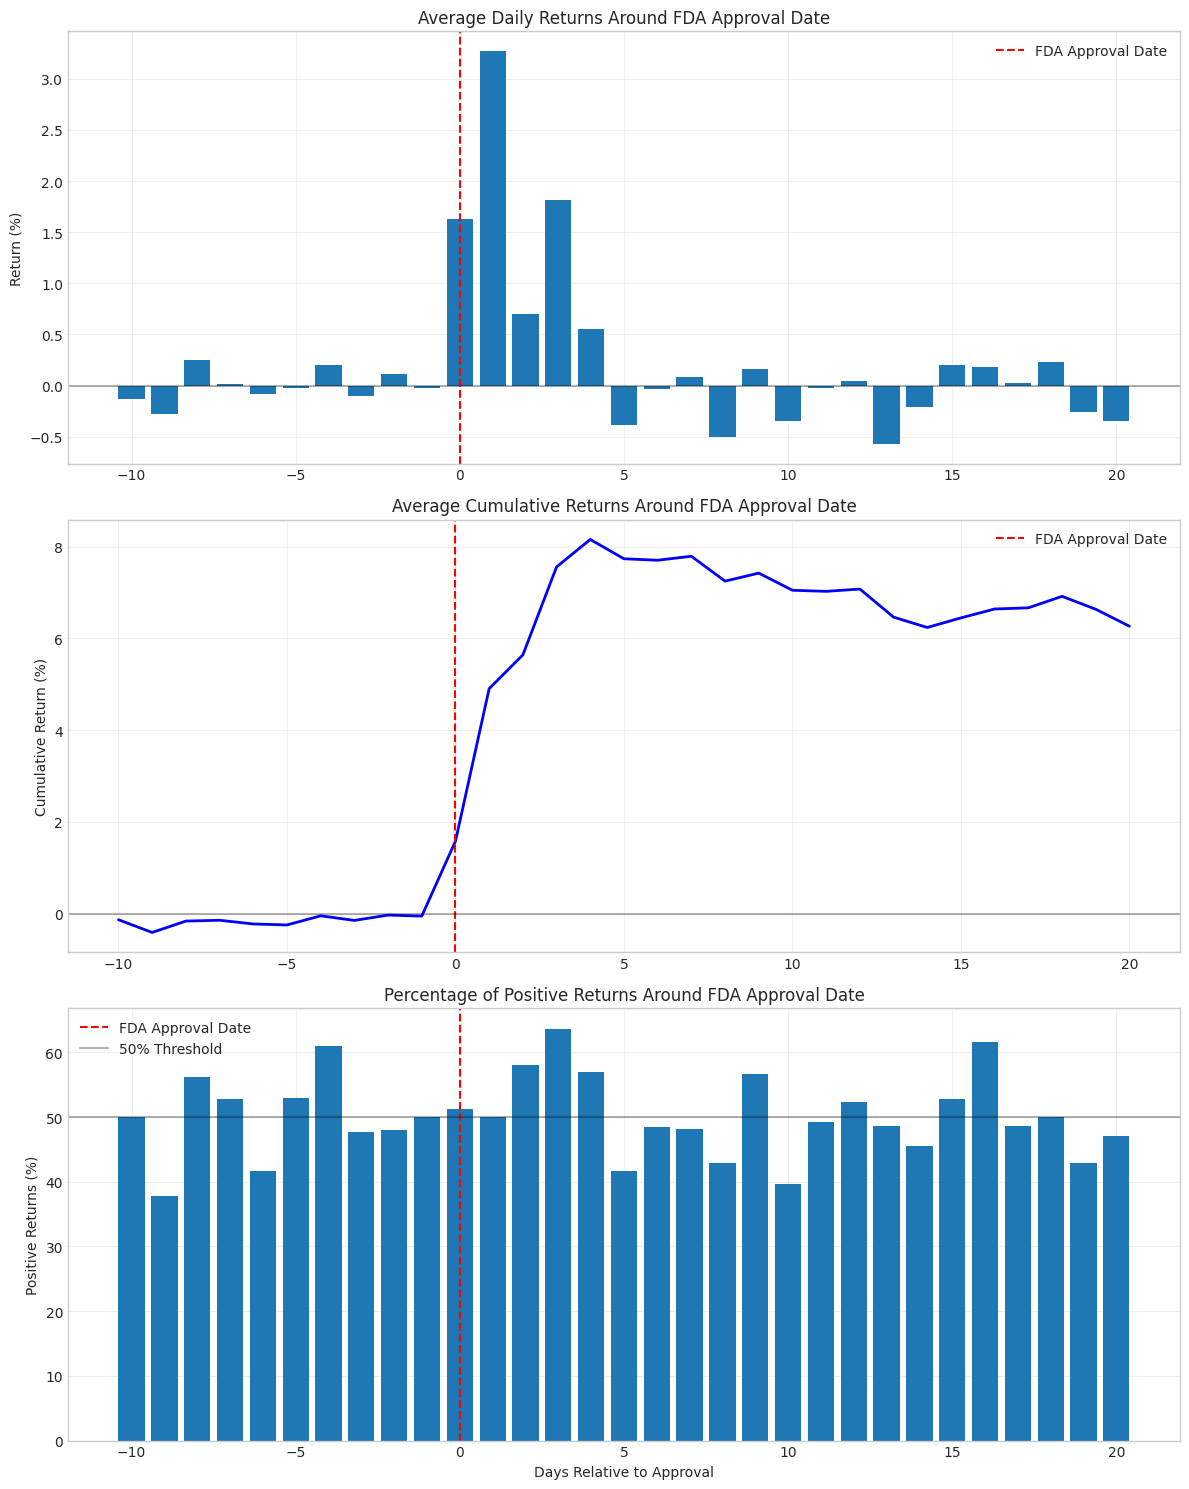

In [28]:
# Plot average returns and percentage of positive returns around approval date
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))

# Daily Average Returns
ax1.bar(aligned_returns.index, aligned_returns['avg_ret'] * 100)
ax1.axvline(x=0, color='r', linestyle='--', label='FDA Approval Date')
ax1.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax1.set_title('Average Daily Returns Around FDA Approval Date')
ax1.set_ylabel('Return (%)')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Cumulative Returns
ax2.plot(aligned_returns.index, aligned_returns['cum_ret'] * 100, 'b-', linewidth=2)
ax2.axvline(x=0, color='r', linestyle='--', label='FDA Approval Date')
ax2.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax2.set_title('Average Cumulative Returns Around FDA Approval Date')
ax2.set_ylabel('Cumulative Return (%)')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Percentage of Positive Returns
ax3.bar(aligned_returns.index, aligned_returns['pos_pct'])
ax3.axvline(x=0, color='r', linestyle='--', label='FDA Approval Date')
ax3.axhline(y=50, color='k', linestyle='-', alpha=0.3, label='50% Threshold')
ax3.set_title('Percentage of Positive Returns Around FDA Approval Date')
ax3.set_xlabel('Days Relative to Approval')
ax3.set_ylabel('Positive Returns (%)')
ax3.grid(True, alpha=0.3)
ax3.legend()

plt.tight_layout()
plt.savefig('results/all_buy_fda/returns_around_approval.png')
plt.show()

## Answers to Key Questions

Based on our analysis, let's answer the key questions:

### What's the directional accuracy if you have a naive model that always buys?

The directional accuracy of the always-buy strategy is equal to the percentage of positive returns in the dataset. From our analysis:

In [29]:
print(f"Directional accuracy of always-buy model: {metrics_df.loc['Direction Accuracy', 'AlwaysBuy']:.2%}")
print(f"Percentage of positive returns: {metrics_df.loc['Positive Returns %', 'AlwaysBuy']:.2f}%")

Directional accuracy of always-buy model: 52.11%
Percentage of positive returns: 52.11%


### Curious since most are approved

This observation is about whether most FDA approvals lead to positive stock returns. Let's analyze the data around FDA approval dates specifically:

In [30]:
# Analyze returns specifically on FDA approval days (day 0)
approval_day_data = data[data['days_to_approval'] == 0]
approval_day_returns = approval_day_data['ret']

print("FDA Approval Day Return Statistics:")
print(f"Number of approval events: {len(approval_day_returns)}")
print(f"Mean return on approval day: {np.mean(approval_day_returns):.6f}")
print(f"Median return on approval day: {np.median(approval_day_returns):.6f}")
print(f"Positive returns: {np.sum(approval_day_returns > 0)} ({np.mean(approval_day_returns > 0):.2%})")
print(f"Negative returns: {np.sum(approval_day_returns < 0)} ({np.mean(approval_day_returns < 0):.2%})")
print(f"Zero returns: {np.sum(approval_day_returns == 0)} ({np.mean(approval_day_returns == 0):.2%})")

# Also look at returns in the days following approval
post_approval_data = data[(data['days_to_approval'] > 0) & (data['days_to_approval'] <= 5)]
post_approval_returns = post_approval_data.groupby(['ticker', 'Approval Date'])['ret'].sum()

print("\nCumulative 5-day Post-Approval Return Statistics:")
print(f"Number of approval events: {len(post_approval_returns)}")
print(f"Mean 5-day return after approval: {np.mean(post_approval_returns):.6f}")
print(f"Median 5-day return after approval: {np.median(post_approval_returns):.6f}")
print(f"Positive 5-day returns: {np.sum(post_approval_returns > 0)} ({np.mean(post_approval_returns > 0):.2%})")
print(f"Negative 5-day returns: {np.sum(post_approval_returns < 0)} ({np.mean(post_approval_returns < 0):.2%})")
print(f"Zero 5-day returns: {np.sum(post_approval_returns == 0)} ({np.mean(post_approval_returns == 0):.2%})")

FDA Approval Day Return Statistics:
Number of approval events: 123
Mean return on approval day: 0.015475
Median return on approval day: 0.000832
Positive returns: 63 (51.22%)
Negative returns: 60 (48.78%)
Zero returns: 0 (0.00%)

Cumulative 5-day Post-Approval Return Statistics:
Number of approval events: 118
Mean 5-day return after approval: 0.033579
Median 5-day return after approval: 0.004911
Positive 5-day returns: 71 (60.17%)
Negative 5-day returns: 47 (39.83%)
Zero 5-day returns: 0 (0.00%)


### Do we add value relative to always buying?

To answer this question, we need to compare the more sophisticated models with the always-buy benchmark:

In [31]:
# Summarize the value added
print("Value Added by Sophisticated Models vs. Always-Buy Strategy:")
for model in value_added_df.columns:
    print(f"\n{model} Model:")
    print(f"  Direction Accuracy Improvement: {value_added_df.loc['Direction Accuracy Improvement', model] * 100:.2f} percentage points")
    print(f"  Sharpe Ratio Improvement: {value_added_df.loc['Sharpe Ratio Improvement', model]:.4f}")
    print(f"  RMSE Improvement: {value_added_df.loc['RMSE Improvement', model]:.6f}")
    print(f"  MAE Improvement: {value_added_df.loc['MAE Improvement', model]:.6f}")
    print(f"  R² Improvement: {value_added_df.loc['R² Improvement', model]:.6f}")

Value Added by Sophisticated Models vs. Always-Buy Strategy:

TimeSeriesRidge Model:
  Direction Accuracy Improvement: -1.92 percentage points
  Sharpe Ratio Improvement: -0.6956
  RMSE Improvement: 0.000114
  MAE Improvement: -0.000244
  R² Improvement: 0.005489

XGBoostDecile Model:
  Direction Accuracy Improvement: 1.52 percentage points
  Sharpe Ratio Improvement: 0.0972
  RMSE Improvement: -0.000962
  MAE Improvement: -0.001141
  R² Improvement: -0.047075


### What's the sharpe of always buying?

Let's calculate the Sharpe ratio of the always-buy strategy:

In [32]:
# Extract the Sharpe ratio of the always-buy model
always_buy_sharpe = metrics_df.loc["Sharpe Ratio", "AlwaysBuy"]
print(f"Sharpe ratio of always-buy strategy: {always_buy_sharpe:.4f}")

# Compare with other models
for name in metrics_df.columns:
    if name != "AlwaysBuy":
        sharpe = metrics_df.loc["Sharpe Ratio", name]
        diff = sharpe - always_buy_sharpe
        print(f"{name} Sharpe ratio: {sharpe:.4f} (difference: {diff:+.4f})")

Sharpe ratio of always-buy strategy: 1.5044
TimeSeriesRidge Sharpe ratio: 0.8088 (difference: -0.6956)
XGBoostDecile Sharpe ratio: 1.6016 (difference: +0.0972)
